In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
import fastai
import pydicom as dicom
from pydicom.filereader import read_dicomdir
from fast_dicom import *

In [3]:
PATH = Path("/home/vhl_ai/Data/MRI/DICOMS")

In [4]:
study_paths = sorted([i for i in (PATH).ls() if 'zip' not in str(i) ])

In [5]:
study_paths

[PosixPath('/home/vhl_ai/Data/MRI/DICOMS/75mm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0083'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0090'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0094'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0099'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0109'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0110'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0111'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0125'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0131'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0141'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0145'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0156'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0157'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0165'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0168'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0197'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0215'),
 PosixPath('/home/vhl_ai/Data/MRI

In [6]:
slices = sorted([i for i in Path('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Raw/').ls()])

In [7]:
len(slices)

104

In [8]:
ref = dicom.read_file(str(slices[0]))
const_dims = (int(ref.Rows), int(ref.Columns), len(slices))
print(const_dims)
const_pix_space = (float(ref.PixelSpacing[0]), float(ref.PixelSpacing[1]), float(ref.SliceThickness))
print(const_pix_space)
              

(512, 512, 104)
(0.29296875, 0.29296875, 1.0)


In [9]:
x = np.arange(0.0, (const_dims[0]+1)*const_pix_space[0], const_pix_space[0])
y = np.arange(0.0, (const_dims[1]+1)*const_pix_space[1], const_pix_space[1])
z = np.arange(0.0, (const_dims[2]+1)*const_pix_space[2], const_pix_space[2])

In [10]:
np.shape(x)

(513,)

In [11]:
array_dicom = np.zeros(const_dims, dtype=ref.pixel_array.dtype)
np.shape(array_dicom)

(512, 512, 104)

In [12]:
for file in slices:
    ds = dicom.read_file(str(file))
    array_dicom[:,:,slices.index(file)] = ds.pixel_array

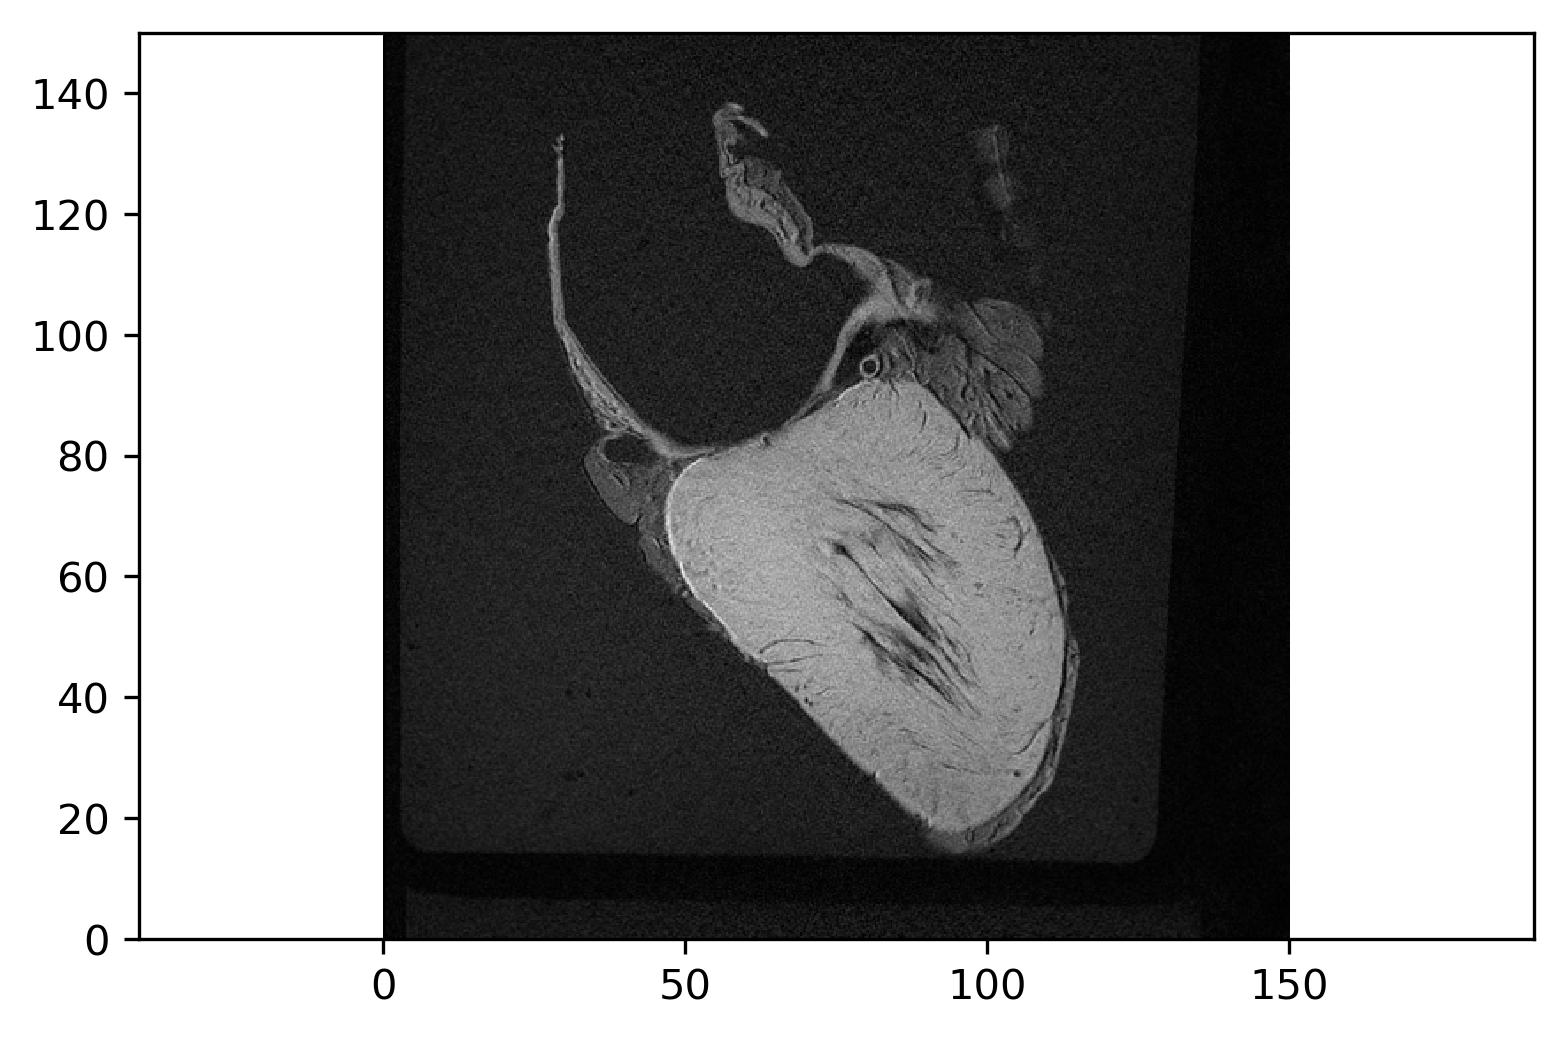

In [159]:
plt.figure(dpi=300)
plt.axes().set_aspect('equal', 'datalim')
plt.set_cmap(plt.gray())
plt.pcolormesh(x, y, np.flipud(array_dicom[:, :, 73]))

In [13]:
mask_slices = sorted([i for i in Path('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/').ls()])
mask_slices

[PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0000.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0001.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0002.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0003.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0004.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0005.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0006.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0007.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0008.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0009.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0010.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0011.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0012.dcm'),
 PosixPath('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0013.dcm'),
 PosixPath('/home/vh

In [14]:
len(mask_slices)

104

In [15]:
ref = dicom.read_file(str(mask_slices[0]))
const_dims = (int(ref.Rows), int(ref.Columns), len(slices))
print(const_dims)
const_pix_space = (float(ref.PixelSpacing[0]), float(ref.PixelSpacing[1]), float(ref.SliceThickness))
print(const_pix_space)

(512, 512, 104)
(0.29296875, 0.29296875, 1.0)


In [16]:
x = np.arange(0.0, (const_dims[0]+1)*const_pix_space[0], const_pix_space[0])
y = np.arange(0.0, (const_dims[1]+1)*const_pix_space[1], const_pix_space[1])
z = np.arange(0.0, (const_dims[2]+1)*const_pix_space[2], const_pix_space[2])

In [17]:
mask_array_dicom = np.zeros(const_dims, dtype=ref.pixel_array.dtype)
np.shape(mask_array_dicom)

(512, 512, 104)

In [20]:
for mask_file in mask_slices:
    ds = dicom.read_file(str(mask_file))
    mask_array_dicom[:,:,mask_slices.index(mask_file)] = ds.pixel_array

In [168]:
ds = dicom.read_file('/home/vhl_ai/Data/MRI/DICOMS/HH0059/Mask/HH59_0000.dcm')

In [169]:
ds

(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113770.2.1.2563393261.2110896889.198573425
(0008, 0020) Study Date                          DA: '20091219'
(0008, 0021) Series Date                         DA: '20091219'
(0008, 0022) Acquisition Date                    DA: ''
(0008, 0023) Content Date                        DA: ''
(0008, 0030) Study Time                          TM: '13510.187000'
(0008, 0031) Series Time                         TM: '13510.187000'
(0008, 0032) Acquisition Time                    TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: 'SIEMENS'
(0008, 0080) Institution Name                    LO: 'UMMC,FAIRVIEW^M2'
(000